In [52]:
# import pytorch libraries
%matplotlib inline
import torch 
import torch.autograd as autograd 
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import re
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv("data/train.csv")

In [3]:
train.shape

(404290, 6)

In [4]:
train.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [5]:
train.is_duplicate.mean()

0.369197853026293

In [6]:
train = train[['question1','question2','is_duplicate']]

In [7]:
train.columns = ['x1','x2','y']

In [8]:
train.shape

(404290, 3)

### Tokenization with Spacy

In [9]:
import spacy

In [10]:
re_br = re.compile(r'<\s*br\s*/?>', re.IGNORECASE)
def sub_br(x): return re_br.sub("\n", x)

my_tok = spacy.load('en')
def spacy_tok(x): return [tok.text for tok in my_tok.tokenizer(sub_br(x))] #x is train_toy['x1'][i]

### Split dataset in train and validation

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
X = train[['x1','x2']].values
y = np.array(train['y'])

In [14]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
X_train[1]

array(['Is this a German Shepherd dog?',
       'Are german shepherd dogs loyal?'], dtype=object)

In [16]:
y_train[1]

0

### Creating Vocabulary

In [17]:
from collections import defaultdict

In [18]:
def get_vocab(content):
    """Computes Dict of counts of words.
    
    Computes the number of times a word is on a document.
    """
    vocab = defaultdict(float)
    for x1,x2 in content:
        line = str(x1)+' '+str(x2)
        words = set(line.split())
        for word in words:
            vocab[word] += 1
    return vocab

In [19]:
word_count = get_vocab(X_train)

In [20]:
vocab2index = {"":0, "UNK":1}
words = ["", "UNK"]
for word in word_count:
    vocab2index[word] = len(words)
    words.append(word)

In [21]:
vocab = word_count.keys()

### Pretrained embeddings

In [23]:
def loadGloveModel(gloveFile='data/glove.6B.100d.txt'):
    """ Loads word vectors into a dictionary."""
    f = open(gloveFile,'r')
    word_vecs = {}
    for line in f:
        splitLine = line.split()
        word = splitLine[0]
        word_vecs[word] = np.array([float(val) for val in splitLine[1:]])
    return word_vecs

In [24]:
word_vecs = loadGloveModel()

In [25]:
def delete_rare_words(word_vecs, word_count, min_df=4):
    """ Deletes rare words from word_count
    
    Deletes words from word_count if they are not in word_vecs
    and don't have at least min_df occurrencies in word_count.
    """
    words_delete = []
    for word in word_count:
        if word_count[word] < min_df and word not in word_vecs:
            words_delete.append(word)
    for word in words_delete: word_count.pop(word)
    return word_count

In [26]:
def create_embedding_matrix(word_vecs, word_count, min_df=4, emb_size=100):
    """Creates embedding matrix from word vectors. """
    word_count = delete_rare_words(word_vecs, word_count, min_df)
    V = len(word_count.keys()) + 2
    vocab2index = {}
    W = np.zeros((V, emb_size), dtype="float32")
    vocab = ["", "UNK"]
    # adding a vector for padding
    W[0] = np.zeros(emb_size, dtype='float32')
    # adding a vector for rare words 
    W[1] = np.random.uniform(-0.25, 0.25, emb_size)
    vocab2index["UNK"] = 1
    vocab2index[""] = 0
    i = 2
    for word in word_count:
        if word in word_vecs:
            W[i] = word_vecs[word]
            vocab2index[word] = i
            vocab.append(word)
            i += 1
        else:
            W[i] = np.random.uniform(-0.25,0.25, emb_size)
            vocab2index[word] = i
            vocab.append(word)
            i += 1   
    return W, np.array(vocab), vocab2index

In [27]:
pretrained_weight, vocab, vocab2index = create_embedding_matrix(word_vecs, word_count)

### DataSet

In [28]:
def encode_sentence_with_padding(sentences, vocab2index):
    s1,s2 = sentences
    s1 = spacy_tok(str(s1))
    s2 = spacy_tok(str(s2))
    if len(s1) >= len(s2):
        s2 = s2 + ["" for _ in range(len(s1)-len(s2))]
    else:
        s1 = s1 + ["" for _ in range(len(s2)-len(s1))]
    return np.array([vocab2index.get(w, vocab2index["UNK"]) for w in s1]),np.array([vocab2index.get(w, vocab2index["UNK"]) for w in s2])

In [29]:
class QuoraDataset(Dataset):
    def __init__(self, X, y):
        self.temp = [encode_sentence_with_padding(sentence, vocab2index) for sentence in X]
        self.x1 = [v[0] for v in self.temp]
        self.x2 = [v[1] for v in self.temp]
        self.y = y
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.x1[idx],self.x2[idx],self.y[idx]

In [30]:
train_ds = QuoraDataset(X_train, y_train)
valid_ds = QuoraDataset(X_val, y_val)

In [31]:
def collate_fn(data):
    """Creates mini-batch tensors from the list of tuples (sentences, labels).
    
    Need custom collate_fn because merging sequences (including padding) is not 
    supported in default. Sequences are padded to the maximum length of mini-batch 
    sequences (dynamic padding).
    
    Args:
        data: list of tuple (sentence, label). 
            - list of word indices of variable length
            - label, 0 or 1
    Returns:
        packed_batch: (PackedSequence), see torch.nn.utils.rnn.pack_padded_sequence
        sencences: torch tensor of shape (batch_size, max_len).
        labels: torch tensor of shape (batch_size, 1).
        lengths: list; valid length for each padded sentence. 
    """
    # Sort a data list by sentences length (descending order).
    data.sort(key=lambda x: len(x[0]), reverse=True)
    s1,s2, labels = zip(*data)
    
    # stack labels
    labels = torch.Tensor(labels)
    
    # Merge sentences
    lengths = [len(s) for s in s1]
   
    sents1 = torch.zeros(len(s1), max(lengths)).long()
    for i, s in enumerate(s1):
        end = lengths[i]
        sents1[i, :end] = torch.Tensor(s[:end]) 
        
 
    sents2 = torch.zeros(len(s2), max(lengths)).long()
    for i, s in enumerate(s2):
        end = lengths[i]
        sents2[i, :end] = torch.Tensor(s[:end])        
    
    return sents1, sents2, lengths, labels

In [32]:
batch_size = 10000
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

### Model

In [33]:
def save_model(m, p): torch.save(m.state_dict(), p)
    
def load_model(m, p): m.load_state_dict(torch.load(p))

In [50]:
def cosine_segment(start_lr, end_lr, iterations):
    i = np.arange(iterations)
    c_i = 1 + np.cos(i*np.pi/iterations)
    return end_lr + (start_lr - end_lr)/2 *c_i

def get_cosine_triangular_lr(max_lr, iterations, div_start=5, div_end=5):
    min_start, min_end = max_lr/div_start, max_lr/div_end
    iter1 = int(0.3*iterations)
    iter2 = iterations - iter1
    segs = [cosine_segment(min_start, max_lr, iter1), cosine_segment(max_lr, min_end, iter2)]
    return np.concatenate(segs)

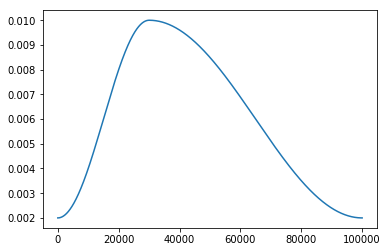

In [53]:
N = 100000
lr = get_cosine_triangular_lr(0.01, N)
plt.plot(list(range(N)), lr)
plt.show()

In [54]:
def update_optimizer(optimizer, lr):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = lr

In [55]:
class GRUModel(torch.nn.Module) :
    def __init__(self, vocab_size, embedding_dim, hidden_dim_1,hidden_dim_2,glove_weights=None) :
        super(GRUModel,self).__init__()
        self.hidden_dim_1 = hidden_dim_1
        self.embeddings_1 = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        if glove_weights is not None:
            self.embeddings_1.weight.data.copy_(torch.from_numpy(glove_weights))
            self.embeddings_1.weight.requires_grad = False ## freeze embeddings           
        self.gru = nn.GRU(embedding_dim, hidden_dim_1, batch_first=True)
        self.linear_1 = nn.Linear(hidden_dim_1, 10)
        self.dropout = nn.Dropout(0.4)
        
        self.hidden_dim_2 = hidden_dim_2
        self.linear_2 = nn.Linear(hidden_dim_2, 10)
        self.dropout = nn.Dropout(0.4)
        
        self.cos = nn.CosineSimilarity(dim=1, eps=1e-6)
        
    def forward(self, x1,x2, lengths):
        x1 = self.embeddings_1(x1)
        x1 = self.dropout(x1)
        x2 = self.embeddings_1(x2)
        x2 = self.dropout(x2)
        pack_1 = pack_padded_sequence(x1, lengths, batch_first=True)
        out_pack_1, ht_1 = self.gru(pack_1)
        pack_2 = pack_padded_sequence(x2, lengths, batch_first=True)
        out_pack_2, ht_2 = self.gru(pack_2)
        x1 = self.linear_1(ht_1[-1])
        x2 = self.linear_2(ht_2[-1])
#         x = torch.cosine_similarity([x1,x2],1)
        return self.cos(x1,x2)

In [56]:
def train_epocs(model, optimizer, train_dl, valid_dl,max_lr=0.05, epochs=10):
    iterations = epochs*len(train_dl)
    idx = 0
    lrs = get_cosine_triangular_lr(max_lr, iterations)
    best_val_acc = 0
    for i in range(epochs):
        model.train()
        sum_loss = 0.0
        total = 0
        for x1, x2, s, y in train_dl:
            x1 = x1.long().cuda()
            x2 = x2.long().cuda()
#             s = s.long.cuda()
            y = y.float().cuda()
            y_pred = model(x1,x2,s)
            optimizer.zero_grad()
            loss = F.binary_cross_entropy_with_logits(y_pred, y)
            loss.backward()
            optimizer.step()
            idx +=1
            sum_loss += loss.item()*y.shape[0]
            total += y.shape[0]
        val_loss, val_acc = val_metrics(model, valid_dl)
        if i % 2 == 1:
            print("train loss %.3f val loss %.3f and val accuracy %.3f" % (sum_loss/total, val_loss, val_acc))  
        if best_val_acc < val_acc:
            best_val_acc = val_acc
            path = "models/model_acc_{0:.3f}_model1_all_cat.pth".format(100*val_acc) 
            save_model(model, path)
            print(path)

In [57]:
def val_metrics(model, valid_dl):
    model.eval()
    correct = 0
    total = 0
    sum_loss = 0.0
    for x1,x2, s, y in valid_dl:
        x1 = x1.long().cuda()
        x2 = x2.long().cuda()
#         s = s.long.cuda()
        y = y.float().cuda()
        y_hat = model(x1,x2, s)
        loss = F.binary_cross_entropy_with_logits(y_hat, y)
        y_pred = y_hat > 0
        correct += (y_pred.float() == y).float().sum()
        total += y.shape[0]
        sum_loss += loss.item()*y.shape[0]
    return sum_loss/total, correct/total

In [58]:
def test_results(model, test_dl):
    model.eval()
    ys = []
#     idx = []
    for x1,x2, s, y in test_dl:
        x1 = x1.long().cuda()
        x2 = x2.long().cuda()
#         s = s.long.cuda()
        y = y.float().cuda()
        y_hat = model(x1,x2, s)
        y_pred = y_hat > 0
        ys.append(int(y_pred.cpu()))
#     idx = np.arange(len(ys))
#     pd.
            
    return ys

In [59]:
model = GRUModel(vocab_size=vocab.shape[0],
                 embedding_dim=100,
                 hidden_dim_1=100,hidden_dim_2=100, glove_weights=pretrained_weight).cuda()

In [60]:
parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = torch.optim.Adam(parameters, lr=0.02, weight_decay=1e-4 )

In [61]:
train_epocs(model, optimizer, train_dl, valid_dl, epochs=100)

models/model_acc_68.252_model1_all_cat.pth
train loss 0.608 val loss 0.590 and val accuracy 0.702
models/model_acc_70.165_model1_all_cat.pth
train loss 0.598 val loss 0.576 and val accuracy 0.718
models/model_acc_71.771_model1_all_cat.pth
models/model_acc_72.251_model1_all_cat.pth
train loss 0.577 val loss 0.572 and val accuracy 0.722
models/model_acc_72.375_model1_all_cat.pth
train loss 0.573 val loss 0.577 and val accuracy 0.715
models/model_acc_73.353_model1_all_cat.pth
train loss 0.568 val loss 0.558 and val accuracy 0.739
models/model_acc_73.932_model1_all_cat.pth
train loss 0.568 val loss 0.563 and val accuracy 0.732
train loss 0.563 val loss 0.557 and val accuracy 0.740
models/model_acc_73.986_model1_all_cat.pth
models/model_acc_74.375_model1_all_cat.pth
train loss 0.561 val loss 0.557 and val accuracy 0.742
train loss 0.567 val loss 0.557 and val accuracy 0.741
models/model_acc_74.700_model1_all_cat.pth
train loss 0.559 val loss 0.550 and val accuracy 0.751
models/model_acc_75.

In [62]:
test_model = GRUModel(vocab_size=vocab.shape[0],
                 embedding_dim=100,
                 hidden_dim_1=100,hidden_dim_2=100, glove_weights=pretrained_weight).cuda() 
load_model(test_model, 'models/model_acc_76.054_model1_all_cat.pth')

In [63]:
test = pd.read_csv("data/test.csv")

In [64]:
test['y'] = 1

In [65]:
test = test[['question1','question2','y']]
test.columns = ['x1','x2','y']
X_test = test[['x1','x2']].values
y_test = np.array(test['y'])
test_ds = QuoraDataset(X_test,y_test)
test_dl = DataLoader(test_ds, shuffle=False,collate_fn=collate_fn, batch_size=1)

In [66]:
import time
t1 = time.time()
ys = test_results(test_model,test_dl)
t2 = time.time()

In [67]:
print((t2-t1)/3600)

0.9649027848243713


In [68]:
test['predictions'] = ys


In [69]:
test['index'] = range(len(ys))

In [70]:
test = test[['index','predictions']]

In [71]:
test.to_csv('test_results.csv', index=False)

In [72]:
test.to_csv('test_results_1.csv')

In [73]:
test.head()

,index,predictions
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [74]:
sample = pd.read_csv("data/sample_submission.csv")

In [75]:
sample.head()

,test_id,is_duplicate
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1


In [76]:
test.columns = ['test_id','is_duplicate']

In [77]:
test.to_csv('test_results.csv', index=False)